In [ ]:
!pip -q install pyriemann

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.7/127.7 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip -q install geomstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 107.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def gen_lorenz(N=4000, dt=0.01, x0=(1.0,1.0,1.0), sigma=10.0, rho=28.0, beta=8/3):
    xs = np.zeros((N,3), dtype=np.float32)
    x = np.array(x0, dtype=np.float32)
    for i in range(N):
        xs[i] = x
        def f(v):
            return np.array([sigma*(v[1]-v[0]),
                             v[0]*(rho - v[2]) - v[1],
                             v[0]*v[1] - beta*v[2]], dtype=np.float32)
        k1 = f(x)
        k2 = f(x + 0.5*dt*k1)
        k3 = f(x + 0.5*dt*k2)
        k4 = f(x + dt*k3)
        x = x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0
    return xs

data = gen_lorenz(N=4000)
obs_dim = data.shape[1]

tau = 2
m = 6
embed_dim = m*obs_dim
L = 21
halfL = L//2
eps_reg = 1e-3

start_idx = (m-1)*tau + halfL
end_idx = data.shape[0] - halfL
T = end_idx - start_idx

X_embed = np.zeros((T, embed_dim), dtype=np.float32)
Y_target = np.zeros((T, obs_dim), dtype=np.float32)

for idx, t in enumerate(range(start_idx, end_idx)):
    vec = []
    for j in range(m):
        vec.append(data[t - j*tau])
    X_embed[idx] = np.concatenate(vec, axis=0)
    Y_target[idx] = data[t]

Cs = np.zeros((T, embed_dim, embed_dim), dtype=np.float32)
for i in range(T):
    win_idx = np.arange(max(0, i-halfL), min(T, i+halfL+1))
    W = X_embed[win_idx]
    mu = W.mean(axis=0, keepdims=True)
    Wc = W - mu
    cov = (Wc.T @ Wc) / Wc.shape[0]
    cov += eps_reg * np.eye(embed_dim, dtype=np.float32)
    Cs[i] = cov

class SPDToYDataset(Dataset):
    def __init__(self, Cs, Ys):
        self.Cs = torch.from_numpy(Cs).float()
        self.Ys = torch.from_numpy(Ys).float()
    def __len__(self):
        return self.Cs.shape[0]
    def __getitem__(self, idx):
        return self.Cs[idx], self.Ys[idx]

dataset = SPDToYDataset(Cs, Y_target)
loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

class BiMapLogMLP(nn.Module):
    def __init__(self, in_dim, k, hidden=[256,128], delta=1e-3, out_dim=3):
        super().__init__()
        self.in_dim = in_dim
        self.k = k
        self.delta = delta
        self.W = nn.Parameter(torch.randn(in_dim, k) * 0.01)
        vech_dim = k*(k+1)//2
        layers = []
        prev = vech_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, out_dim))
        self.mlp = nn.Sequential(*layers)

    def forward(self, C_batch):
        B = C_batch.shape[0]
        W = self.W
        Cw = torch.matmul(C_batch, W)
        Wt = W.t().unsqueeze(0).expand(B, -1, -1)
        V = torch.bmm(Wt, Cw)
        V = V + self.delta * torch.eye(self.k, device=V.device).unsqueeze(0)
        eigvals, eigvecs = torch.linalg.eigh(V)
        eigvals = torch.clamp(eigvals, min=1e-12)
        log_eig = torch.log(eigvals)
        logV = torch.matmul(eigvecs * log_eig.unsqueeze(-2), eigvecs.transpose(-2,-1))
        iu = torch.triu_indices(self.k, self.k)
        vech = logV[:, iu[0], iu[1]]
        y_pred = self.mlp(vech)
        return y_pred

k = 6
model = BiMapLogMLP(in_dim=embed_dim, k=k, hidden=[256,128], delta=1e-3, out_dim=obs_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

epochs = 40
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for C_batch, y_batch in loader:
        C_batch = C_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(C_batch)
        loss = mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * C_batch.size(0)
    avg_loss = total_loss / len(dataset)
    model.eval()
    with torch.no_grad():
        C_all = torch.from_numpy(Cs).to(device)
        Y_all = torch.from_numpy(Y_target).to(device)
        y_pred_all = model(C_all)
        val_mse = mse_loss(y_pred_all, Y_all).item()
    print(f"Epoch {epoch+1}/{epochs}  train_loss={avg_loss:.6e}  val_mse={val_mse:.6e}")

print("Example predictions vs targets (first 10):")
for i in range(10):
    print("pred:", y_pred_all[i].cpu().numpy(), " tgt:", Y_all[i].cpu().numpy())




Using device: cuda
Epoch 1/40  train_loss=1.049167e+02  val_mse=4.763422e+01
Epoch 2/40  train_loss=2.398069e+01  val_mse=9.433125e+00
Epoch 3/40  train_loss=6.014600e+00  val_mse=3.684401e+00
Epoch 4/40  train_loss=2.804966e+00  val_mse=2.097658e+00
Epoch 5/40  train_loss=1.724847e+00  val_mse=1.443491e+00
Epoch 6/40  train_loss=1.242511e+00  val_mse=1.029730e+00
Epoch 7/40  train_loss=9.786528e-01  val_mse=8.624482e-01
Epoch 8/40  train_loss=7.933283e-01  val_mse=6.767597e-01
Epoch 9/40  train_loss=6.406553e-01  val_mse=6.098462e-01
Epoch 10/40  train_loss=5.565401e-01  val_mse=4.869466e-01
Epoch 11/40  train_loss=4.794718e-01  val_mse=4.504620e-01
Epoch 12/40  train_loss=4.091854e-01  val_mse=3.856630e-01
Epoch 13/40  train_loss=3.646869e-01  val_mse=3.317343e-01
Epoch 14/40  train_loss=3.311132e-01  val_mse=2.805625e-01
Epoch 15/40  train_loss=2.869332e-01  val_mse=2.551877e-01
Epoch 16/40  train_loss=2.441435e-01  val_mse=2.326245e-01
Epoch 17/40  train_loss=2.323331e-01  val_mse=

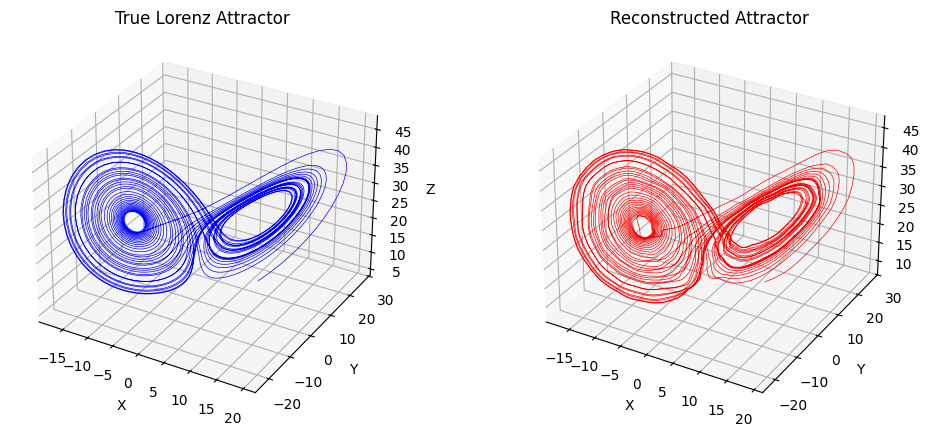

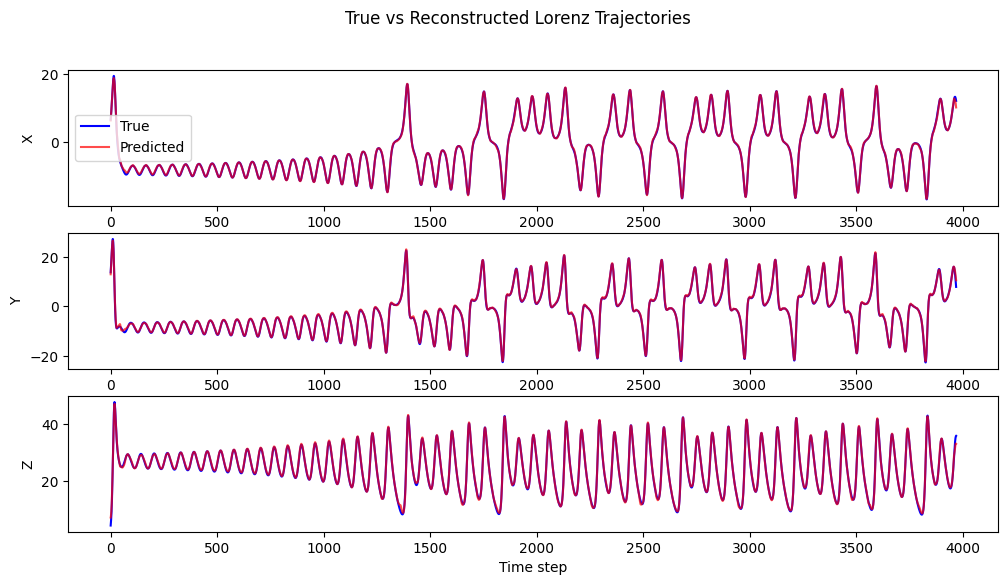

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

model.eval()
with torch.no_grad():
    C_all = torch.from_numpy(Cs).to(device)
    Y_all = torch.from_numpy(Y_target).to(device)
    y_pred_all = model(C_all)

Y_true = Y_all.cpu().numpy()
Y_pred = y_pred_all.cpu().numpy()

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(Y_true[:,0], Y_true[:,1], Y_true[:,2], lw=0.5, color='blue')
ax1.set_title("True Lorenz Attractor")
ax1.set_xlabel("X"); ax1.set_ylabel("Y"); ax1.set_zlabel("Z")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(Y_pred[:,0], Y_pred[:,1], Y_pred[:,2], lw=0.5, color='red')
ax2.set_title("Reconstructed Attractor")
ax2.set_xlabel("X"); ax2.set_ylabel("Y"); ax2.set_zlabel("Z")

plt.show()

fig, axs = plt.subplots(3,1, figsize=(12,6))
labels = ['X','Y','Z']
for i in range(3):
    axs[i].plot(Y_true[:,i], label='True', color='blue')
    axs[i].plot(Y_pred[:,i], label='Predicted', color='red', alpha=0.7)
    axs[i].set_ylabel(labels[i])
axs[-1].set_xlabel("Time step")
axs[0].legend()
plt.suptitle("True vs Reconstructed Lorenz Trajectories")
plt.show()


Epoch 1/40, train_loss=6.301569e+01
Epoch 2/40, train_loss=9.546696e+00
Epoch 3/40, train_loss=1.061808e+00
Epoch 4/40, train_loss=5.488934e-01
Epoch 5/40, train_loss=4.202917e-01
Epoch 6/40, train_loss=2.653103e-01
Epoch 7/40, train_loss=1.994843e-01
Epoch 8/40, train_loss=1.476868e-01
Epoch 9/40, train_loss=1.316134e-01
Epoch 10/40, train_loss=1.151331e-01
Epoch 11/40, train_loss=1.132393e-01
Epoch 12/40, train_loss=8.993277e-02
Epoch 13/40, train_loss=7.698035e-02
Epoch 14/40, train_loss=7.269933e-02
Epoch 15/40, train_loss=6.952175e-02
Epoch 16/40, train_loss=6.633889e-02
Epoch 17/40, train_loss=5.897062e-02
Epoch 18/40, train_loss=5.390023e-02
Epoch 19/40, train_loss=4.384505e-02
Epoch 20/40, train_loss=4.305419e-02
Epoch 21/40, train_loss=6.729501e-02
Epoch 22/40, train_loss=3.894994e-02
Epoch 23/40, train_loss=3.624457e-02
Epoch 24/40, train_loss=4.946799e-02
Epoch 25/40, train_loss=3.520754e-02
Epoch 26/40, train_loss=5.032665e-02
Epoch 27/40, train_loss=5.011047e-02
Epoch 28/4

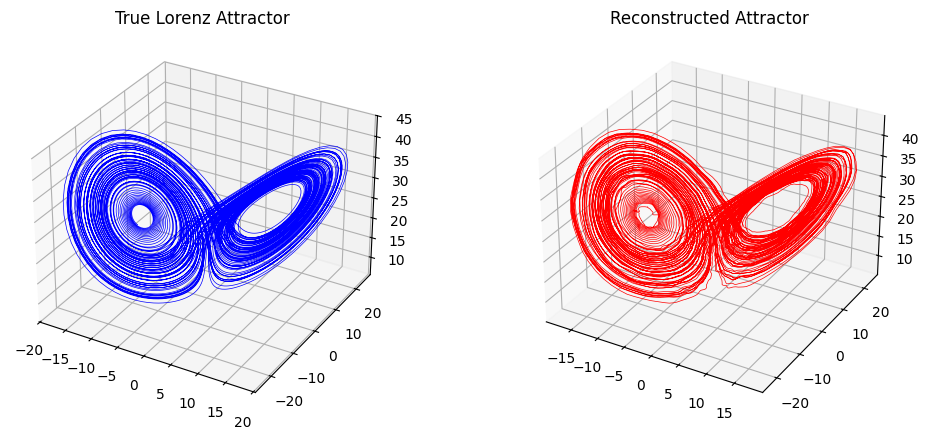

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gen_lorenz(N=4000, dt=0.01, x0=(1.0,1.0,1.0), sigma=10.0, rho=28.0, beta=8/3):
    xs = np.zeros((N,3), dtype=np.float32)
    x = np.array(x0, dtype=np.float32)
    for i in range(N):
        xs[i] = x
        def f(v):
            return np.array([sigma*(v[1]-v[0]),
                             v[0]*(rho - v[2]) - v[1],
                             v[0]*v[1] - beta*v[2]], dtype=np.float32)
        k1 = f(x)
        k2 = f(x + 0.5*dt*k1)
        k3 = f(x + 0.5*dt*k2)
        k4 = f(x + dt*k3)
        x = x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0
    return xs

data = gen_lorenz(N=10000)
obs_dim = data.shape[1]

def nonlinear_map(Y):
    X, Yc, Z = Y[:,0], Y[:,1], Y[:,2]
    return np.stack([np.sin(X)+0.5*Yc, np.log(np.abs(Yc)+1)+Z**2, np.tanh(Z)+X], axis=1)

data_nl = nonlinear_map(data)

tau = 10
m = 8
embed_dim = m*obs_dim
L = 21
halfL = L//2
eps_reg = 1e-3

start_idx = (m-1)*tau + halfL
end_idx = data.shape[0] - halfL
T = end_idx - start_idx

X_embed = np.zeros((T, embed_dim), dtype=np.float32)
Y_target = np.zeros((T, obs_dim), dtype=np.float32)

for idx, t in enumerate(range(start_idx, end_idx)):
    vec = []
    for j in range(m):
        vec.append(data_nl[t - j*tau])
    X_embed[idx] = np.concatenate(vec, axis=0)
    Y_target[idx] = data[t]

Cs = np.zeros((T, embed_dim, embed_dim), dtype=np.float32)
for i in range(T):
    win_idx = np.arange(max(0, i-halfL), min(T, i+halfL+1))
    W = X_embed[win_idx]
    mu = W.mean(axis=0, keepdims=True)
    Wc = W - mu
    cov = (Wc.T @ Wc) / Wc.shape[0]
    cov += eps_reg * np.eye(embed_dim, dtype=np.float32)
    Cs[i] = cov

class SPDToYDataset(Dataset):
    def __init__(self, Cs, Ys):
        self.Cs = torch.from_numpy(Cs).float()
        self.Ys = torch.from_numpy(Ys).float()
    def __len__(self):
        return self.Cs.shape[0]
    def __getitem__(self, idx):
        return self.Cs[idx], self.Ys[idx]

dataset = SPDToYDataset(Cs, Y_target)
loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

class BiMapLogMLP(nn.Module):
    def __init__(self, in_dim, k, hidden=[256,128], delta=1e-3, out_dim=3):
        super().__init__()
        self.in_dim = in_dim
        self.k = k
        self.delta = delta
        self.W = nn.Parameter(torch.randn(in_dim, k)*0.01)
        vech_dim = k*(k+1)//2
        layers = []
        prev = vech_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, out_dim))
        self.mlp = nn.Sequential(*layers)

    def forward(self, C_batch):
        B = C_batch.shape[0]
        W = self.W
        Cw = torch.matmul(C_batch, W) # [B, n, k]
        Wt = W.t().unsqueeze(0).expand(B,-1,-1) # [B,k,n]
        V = torch.bmm(Wt, Cw) # [B,k,k]
        V = V + self.delta*torch.eye(self.k, device=V.device).unsqueeze(0)
        eigvals, eigvecs = torch.linalg.eigh(V)
        eigvals = torch.clamp(eigvals, min=1e-12)
        log_eig = torch.log(eigvals)
        logV = torch.matmul(eigvecs * log_eig.unsqueeze(-2), eigvecs.transpose(-2,-1))
        iu = torch.triu_indices(self.k, self.k)
        vech = logV[:, iu[0], iu[1]]
        y_pred = self.mlp(vech)
        return y_pred

k = 6
model = BiMapLogMLP(in_dim=embed_dim, k=k, hidden=[256,128], delta=1e-3, out_dim=obs_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

epochs = 40
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for C_batch, y_batch in loader:
        C_batch = C_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(C_batch)
        loss = mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * C_batch.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{epochs}, train_loss={avg_loss:.6e}")

model.eval()
with torch.no_grad():
    C_all = torch.from_numpy(Cs).to(device)
    y_pred_all = model(C_all).cpu().numpy()

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(Y_target[:,0], Y_target[:,1], Y_target[:,2], lw=0.5, color='blue')
ax1.set_title("True Lorenz Attractor")
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(y_pred_all[:,0], y_pred_all[:,1], y_pred_all[:,2], lw=0.5, color='red')
ax2.set_title("Reconstructed Attractor")
plt.show()


Using device: cuda
Epoch 1/40, train_loss=6.502168e+01
Epoch 2/40, train_loss=4.093373e+01
Epoch 3/40, train_loss=9.789779e+00
Epoch 4/40, train_loss=1.994474e+00
Epoch 5/40, train_loss=1.074069e+00
Epoch 6/40, train_loss=6.565034e-01
Epoch 7/40, train_loss=5.254814e-01
Epoch 8/40, train_loss=4.432625e-01
Epoch 9/40, train_loss=3.770559e-01
Epoch 10/40, train_loss=2.876111e-01
Epoch 11/40, train_loss=2.544970e-01
Epoch 12/40, train_loss=2.212032e-01
Epoch 13/40, train_loss=2.267516e-01
Epoch 14/40, train_loss=1.896067e-01
Epoch 15/40, train_loss=1.652741e-01
Epoch 16/40, train_loss=1.459921e-01
Epoch 17/40, train_loss=1.526401e-01
Epoch 18/40, train_loss=1.306979e-01
Epoch 19/40, train_loss=1.395102e-01
Epoch 20/40, train_loss=1.311009e-01
Epoch 21/40, train_loss=1.198029e-01
Epoch 22/40, train_loss=1.259753e-01
Epoch 23/40, train_loss=9.752770e-02
Epoch 24/40, train_loss=8.595498e-02
Epoch 25/40, train_loss=1.233815e-01
Epoch 26/40, train_loss=8.343088e-02
Epoch 27/40, train_loss=7.54

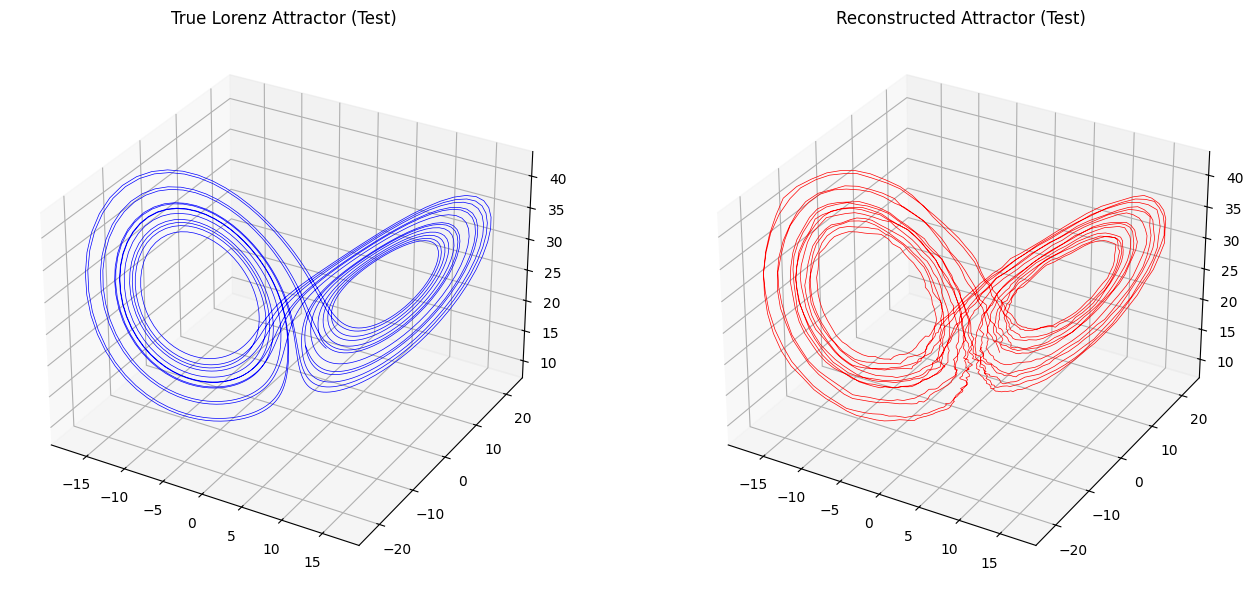

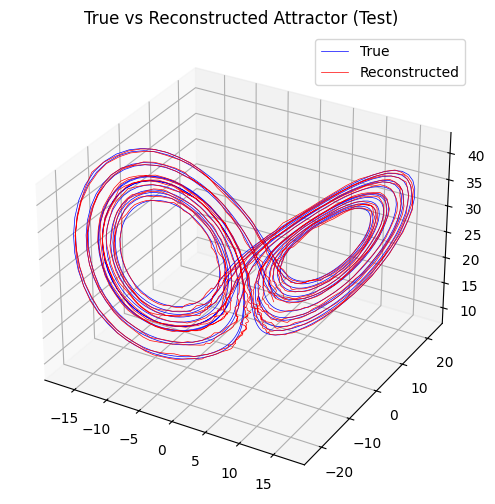

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")

def gen_lorenz(N=4000, dt=0.01, x0=(1.0,1.0,1.0), sigma=10.0, rho=28.0, beta=8/3):
    xs = np.zeros((N,3), dtype=np.float32)
    x = np.array(x0, dtype=np.float32)
    for i in range(N):
        xs[i] = x
        def f(v):
            return np.array([sigma*(v[1]-v[0]),
                             v[0]*(rho - v[2]) - v[1],
                             v[0]*v[1] - beta*v[2]], dtype=np.float32)
        k1 = f(x)
        k2 = f(x + 0.5*dt*k1)
        k3 = f(x + 0.5*dt*k2)
        k4 = f(x + dt*k3)
        x = x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0
    return xs

data = gen_lorenz(N=10000)
obs_dim = data.shape[1]

def nonlinear_map(Y):
    X, Yc, Z = Y[:,0], Y[:,1], Y[:,2]
    X_nl = np.stack([np.sin(X)+0.5*Yc,
                     np.log(np.abs(Yc)+1)+Z**2,
                     np.tanh(Z)+X], axis=1)
    X_nl += np.random.normal(0, 1, size=X_nl.shape).astype(np.float32)
    return X_nl


data_nl = nonlinear_map(data)

tau = 10
m = 8
embed_dim = m*obs_dim
L = 21
halfL = L//2
eps_reg = 1e-3

start_idx = (m-1)*tau + halfL
end_idx = data.shape[0] - halfL
T = end_idx - start_idx

X_embed = np.zeros((T, embed_dim), dtype=np.float32)
Y_target = np.zeros((T, obs_dim), dtype=np.float32)

for idx, t in enumerate(range(start_idx, end_idx)):
    vec = []
    for j in range(m):
        vec.append(data_nl[t - j*tau])
    X_embed[idx] = np.concatenate(vec, axis=0)
    Y_target[idx] = data[t]

Cs = np.zeros((T, embed_dim, embed_dim), dtype=np.float32)
for i in range(T):
    win_idx = np.arange(max(0, i-halfL), min(T, i+halfL+1))
    W = X_embed[win_idx]
    mu = W.mean(axis=0, keepdims=True)
    Wc = W - mu
    cov = (Wc.T @ Wc) / Wc.shape[0]
    cov += eps_reg * np.eye(embed_dim, dtype=np.float32)
    Cs[i] = cov

class SPDToYDataset(Dataset):
    def __init__(self, Cs, Ys):
        self.Cs = torch.from_numpy(Cs).float()
        self.Ys = torch.from_numpy(Ys).float()
    def __len__(self):
        return self.Cs.shape[0]
    def __getitem__(self, idx):
        return self.Cs[idx], self.Ys[idx]

dataset = SPDToYDataset(Cs, Y_target)
loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

class BiMapLogMLP(nn.Module):
    def __init__(self, in_dim, k, hidden=[256,128], delta=1e-3, out_dim=3):
        super().__init__()
        self.in_dim = in_dim
        self.k = k
        self.delta = delta
        self.W = nn.Parameter(torch.randn(in_dim, k)*0.01)
        vech_dim = k*(k+1)//2
        layers = []
        prev = vech_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, out_dim))
        self.mlp = nn.Sequential(*layers)

    def forward(self, C_batch):
        B = C_batch.shape[0]
        W = self.W
        Cw = torch.matmul(C_batch, W)
        Wt = W.t().unsqueeze(0).expand(B,-1,-1)
        V = torch.bmm(Wt, Cw)
        V = V + self.delta*torch.eye(self.k, device=V.device).unsqueeze(0)
        eigvals, eigvecs = torch.linalg.eigh(V)
        eigvals = torch.clamp(eigvals, min=1e-12)
        log_eig = torch.log(eigvals)
        logV = torch.matmul(eigvecs * log_eig.unsqueeze(-2), eigvecs.transpose(-2,-1))
        iu = torch.triu_indices(self.k, self.k)
        vech = logV[:, iu[0], iu[1]]
        y_pred = self.mlp(vech)
        return y_pred

k = 6
model = BiMapLogMLP(in_dim=embed_dim, k=k, hidden=[256,128], delta=1e-3, out_dim=obs_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

epochs = 40
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for C_batch, y_batch in loader:
        C_batch = C_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(C_batch)
        loss = mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * C_batch.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{epochs}, train_loss={avg_loss:.6e}")

test_start = int(0.8 * T)
C_test = torch.from_numpy(Cs[test_start:]).float().to(device)
Y_test = Y_target[test_start:]

model.eval()
with torch.no_grad():
    y_test_pred = model(C_test).cpu().numpy()

mse = mean_squared_error(Y_test, y_test_pred)
mae = mean_absolute_error(Y_test, y_test_pred)
print(f"Test MSE: {mse:.6e}")
print(f"Test MAE: {mae:.6e}")

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(Y_test[:,0], Y_test[:,1], Y_test[:,2], lw=0.5, color='blue')
ax1.set_title("True Lorenz Attractor (Test)")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(y_test_pred[:,0], y_test_pred[:,1], y_test_pred[:,2], lw=0.5, color='red')
ax2.set_title("Reconstructed Attractor (Test)")
plt.tight_layout()
plt.show()

fig2 = plt.figure(figsize=(8,6))
ax = fig2.add_subplot(111, projection='3d')
ax.plot(Y_test[:,0], Y_test[:,1], Y_test[:,2], lw=0.5, color='blue', label='True')
ax.plot(y_test_pred[:,0], y_test_pred[:,1], y_test_pred[:,2], lw=0.5, color='red', label='Reconstructed')
ax.set_title("True vs Reconstructed Attractor (Test)")
ax.legend()
plt.show()


In [ ]:
!pip install git+https://gitlab.lip6.fr/schwander/torchspdnet.git


  Cloning https://gitlab.lip6.fr/schwander/torchspdnet.git to /tmp/pip-req-build-l_62_bds
  Running command git clone --filter=blob:none --quiet https://gitlab.lip6.fr/schwander/torchspdnet.git /tmp/pip-req-build-l_62_bds
  Resolved https://gitlab.lip6.fr/schwander/torchspdnet.git to commit 4bc358a93273164cdc6f72bc7d6364ccc137bb9d
  Preparing metadata (setup.py) ... done
  Created wheel for Torchspdnet: filename=Torchspdnet-0.1-py3-none-any.whl size=6927 sha256=7f7e0156e1884457dd9fa598ca9e714e621ce5dd18390f99204436ad540e9769
  Stored in directory: /tmp/pip-ephem-wheel-cache-nuc1bkf4/wheels/44/66/ab/ddc812d49e252af112b66545958da05af4b3ac63a01ffcac6d
Successfully built Torchspdnet


In [ ]:
!pip -q install geoopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip -q install geoopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 7.3 MB/s eta 0:00:00


Using device: cuda
Epoch 1/2500, train_loss=2.380752e+02
Epoch 2/2500, train_loss=1.346545e+02
Epoch 3/2500, train_loss=6.409087e+01
Epoch 4/2500, train_loss=5.658240e+01
Epoch 5/2500, train_loss=5.316883e+01
Epoch 6/2500, train_loss=5.101953e+01
Epoch 7/2500, train_loss=4.940744e+01
Epoch 8/2500, train_loss=4.807881e+01
Epoch 9/2500, train_loss=4.699262e+01
Epoch 10/2500, train_loss=4.640807e+01
Epoch 11/2500, train_loss=4.590764e+01
Epoch 12/2500, train_loss=4.553227e+01
Epoch 13/2500, train_loss=4.532683e+01
Epoch 14/2500, train_loss=4.515625e+01
Epoch 15/2500, train_loss=4.495777e+01
Epoch 16/2500, train_loss=4.489123e+01
Epoch 17/2500, train_loss=4.478411e+01
Epoch 18/2500, train_loss=4.474503e+01
Epoch 19/2500, train_loss=4.462581e+01
Epoch 20/2500, train_loss=4.461231e+01
Epoch 21/2500, train_loss=4.452194e+01
Epoch 22/2500, train_loss=4.435905e+01
Epoch 23/2500, train_loss=4.431101e+01
Epoch 24/2500, train_loss=4.423482e+01
Epoch 25/2500, train_loss=4.405884e+01
Epoch 26/2500, 

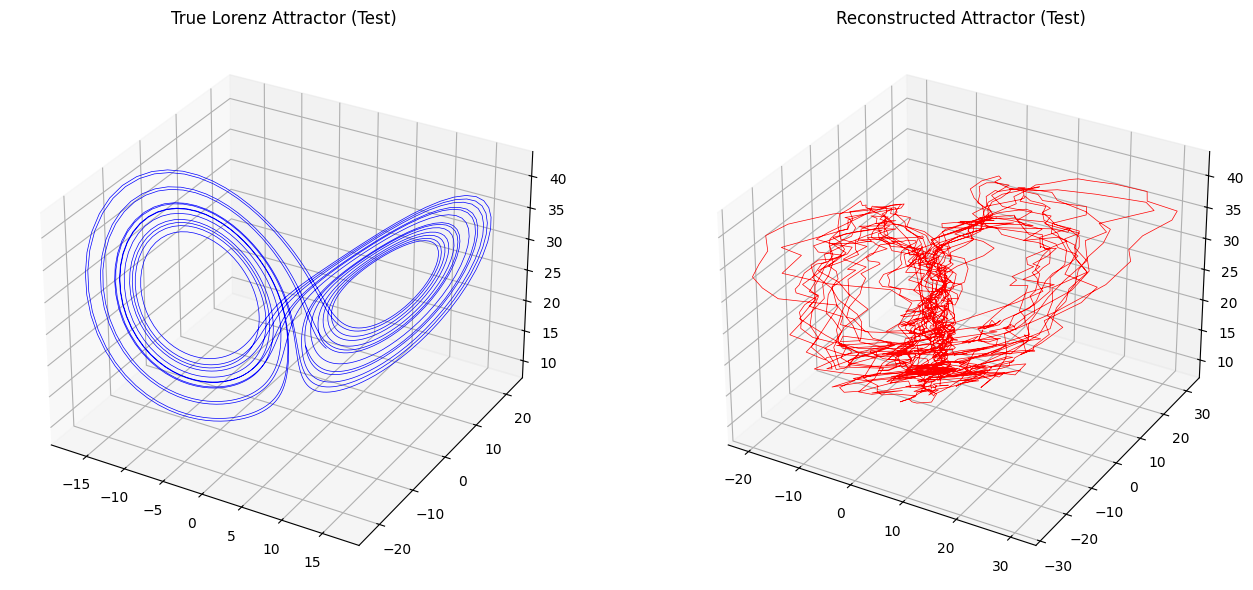

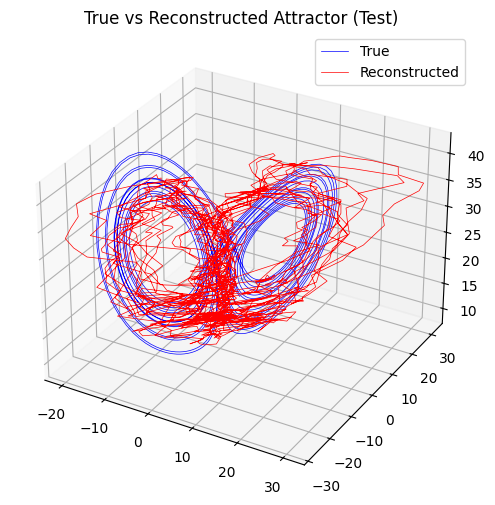

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import geoopt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")

def gen_lorenz(N=10000, dt=0.01, x0=(1.0,1.0,1.0), sigma=10.0, rho=28.0, beta=8/3):
    xs = np.zeros((N,3), dtype=np.float32)
    x = np.array(x0, dtype=np.float32)
    for i in range(N):
        xs[i] = x
        def f(v):
            return np.array([sigma*(v[1]-v[0]),
                             v[0]*(rho - v[2]) - v[1],
                             v[0]*v[1] - beta*v[2]], dtype=np.float32)
        k1 = f(x)
        k2 = f(x + 0.5*dt*k1)
        k3 = f(x + 0.5*dt*k2)
        k4 = f(x + dt*k3)
        x = x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0
    return xs

data = gen_lorenz(N=10000)
obs_dim = data.shape[1]

def nonlinear_map(Y):
    X, Yc, Z = Y[:,0], Y[:,1], Y[:,2]
    X_nl = np.stack([np.sin(X)+0.5*Yc,
                     np.log(np.abs(Yc)+1)+Z**2,
                     np.tanh(Z)+X], axis=1)
    X_nl += np.random.normal(0, 1, size=X_nl.shape).astype(np.float32)
    return X_nl

data_nl = nonlinear_map(data)

tau = 10
m = 8
embed_dim = m*obs_dim
L = 21
halfL = L//2
eps_reg = 1e-3

start_idx = (m-1)*tau + halfL
end_idx = data.shape[0] - halfL
T = end_idx - start_idx

X_embed = np.zeros((T, embed_dim), dtype=np.float32)
Y_target = np.zeros((T, obs_dim), dtype=np.float32)

for idx, t in enumerate(range(start_idx, end_idx)):
    vec = []
    for j in range(m):
        vec.append(data_nl[t - j*tau])
    X_embed[idx] = np.concatenate(vec, axis=0)
    Y_target[idx] = data[t]

Cs = np.zeros((T, embed_dim, embed_dim), dtype=np.float32)
for i in range(T):
    win_idx = np.arange(max(0, i-halfL), min(T, i+halfL+1))
    W = X_embed[win_idx]
    mu = W.mean(axis=0, keepdims=True)
    Wc = W - mu
    cov = (Wc.T @ Wc) / Wc.shape[0]
    cov += eps_reg * np.eye(embed_dim, dtype=np.float32)
    Cs[i] = cov

class SPDToYDataset(Dataset):
    def __init__(self, Cs, Ys):
        self.Cs = torch.from_numpy(Cs).float()
        self.Ys = torch.from_numpy(Ys).float()
    def __len__(self):
        return self.Cs.shape[0]
    def __getitem__(self, idx):
        return self.Cs[idx], self.Ys[idx]

dataset = SPDToYDataset(Cs, Y_target)
loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

class BiMap(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        if out_dim > in_dim:
            raise ValueError("For Stiefel manifold, out_dim <= in_dim")
        W = torch.randn(in_dim, out_dim) * 0.01
        self.W = geoopt.ManifoldParameter(W, manifold=geoopt.Stiefel())

    def forward(self, X):
        return self.W.T @ X @ self.W

class ReEig(nn.Module):
    def __init__(self, eps=1e-3):
        super().__init__()
        self.eps = eps

    def forward(self, X):
        eigvals, eigvecs = torch.linalg.eigh(X)
        eigvals = torch.clamp(eigvals, min=self.eps)
        return eigvecs @ torch.diag_embed(eigvals) @ eigvecs.transpose(-2,-1)

class LogEig(nn.Module):
    def forward(self, X):
        eigvals, eigvecs = torch.linalg.eigh(X)
        log_eigvals = torch.log(eigvals)
        return eigvecs @ torch.diag_embed(log_eigvals) @ eigvecs.transpose(-2,-1)

class SPDNet(nn.Module):
    def __init__(self, input_dim, k=6, hidden=[128,64], out_dim=3, delta=1e-3):
        super().__init__()
        self.bimap = BiMap(input_dim, k)
        self.reeig = ReEig(eps=delta)
        self.logeig = LogEig()
        vech_dim = k*(k+1)//2
        layers = []
        prev = vech_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, out_dim))
        self.mlp = nn.Sequential(*layers)
        self.k = k
        self.vech_dim = vech_dim

    def forward(self, X):
        X = self.bimap(X)
        X = self.reeig(X)
        X = self.logeig(X)
        idx = torch.triu_indices(self.k, self.k)
        vech = X[:, idx[0], idx[1]]
        y_pred = self.mlp(vech)
        return y_pred

model = SPDNet(input_dim=embed_dim, k=6).to(device)
mse_loss = nn.MSELoss()
optimizer = geoopt.optim.RiemannianAdam(model.parameters(), lr=1e-3)

epochs = 1000
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for C_batch, y_batch in loader:
        C_batch = C_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(C_batch)
        loss = mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * C_batch.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{epochs}, train_loss={avg_loss:.6e}")


test_start = int(0.8 * T)
C_test = torch.from_numpy(Cs[test_start:]).float().to(device)
Y_test = Y_target[test_start:]

model.eval()
with torch.no_grad():
    y_test_pred = model(C_test).cpu().numpy()

mse = mean_squared_error(Y_test, y_test_pred)
mae = mean_absolute_error(Y_test, y_test_pred)
print(f"Test MSE: {mse:.6e}")
print(f"Test MAE: {mae:.6e}")

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(Y_test[:,0], Y_test[:,1], Y_test[:,2], lw=0.5, color='blue')
ax1.set_title("True Lorenz Attractor (Test)")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(y_test_pred[:,0], y_test_pred[:,1], y_test_pred[:,2], lw=0.5, color='red')
ax2.set_title("Reconstructed Attractor (Test)")
plt.tight_layout()
plt.show()

fig2 = plt.figure(figsize=(8,6))
ax = fig2.add_subplot(111, projection='3d')
ax.plot(Y_test[:,0], Y_test[:,1], Y_test[:,2], lw=0.5, color='blue', label='True')
ax.plot(y_test_pred[:,0], y_test_pred[:,1], y_test_pred[:,2], lw=0.5, color='red', label='Reconstructed')
ax.set_title("True vs Reconstructed Attractor (Test)")
ax.legend()
plt.show()


In [ ]:
!pip -q install \
absl-py==1.2.0 aiohttp==3.8.1 aiosignal==1.2.0 alembic==1.13.2 anyio==3.6.2 appdirs==1.4.4 \
argparse argon2-cffi==21.1.0 arrow==1.2.3 art==5.7 asttokens==2.0.5 attrs==22.1.0 \
backcall==0.2.0 beautifulsoup4==4.11.1 bleach==4.1.0 cachetools==5.3.0 certifi==2022.12.7 \
cffi==1.15.1 chardet==4.0.0 charset-normalizer==2.0.7 click==8.1.3 colorama==0.4.4 \
colorlog==6.8.2 cycler==0.11.0 decorator==5.1.1 defusedxml==0.7.1 einops==0.8.0 \
flatbuffers==23.3.3 fsspec==2023.5.0 future==0.18.3 gast==0.4.0 geomstats==2.3.1 \
geoopt==0.5.0 h5py==3.11.0 idna==2.10 imageio==2.10.5 ipython==7.28.0 ipykernel==6.4.2 \
jupyter==1.0.0 jupyterlab==3.5.3 keras==2.11.0 matplotlib==3.7.0 numpy==1.24.2 \
optuna==3.6.1 pandas==1.5.3 plotly==5.4.0 pyyaml==6.0 requests==2.28.2 \
scikit-learn==1.5.1 scipy==1.10.1 seaborn==0.12.2 skorch==0.12.1 sympy==1.9 \
tensorboard==2.11.2 tensorflow==2.11.0 \
torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1+cu116 \
-f https://download.pytorch.org/whl/cu116/torch_stable.html \
torchspdnet==0.1 tqdm==4.65.0 wandb==0.14.2 yarl==1.7.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 23.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.5/508.5 kB 30.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 40.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 29.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 108.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1


In [ ]:
!pip install git+https://github.com/username/torchspdnet.git


  Cloning https://github.com/username/torchspdnet.git to /tmp/pip-req-build-mvhc9i6g
  Running command git clone --filter=blob:none --quiet https://github.com/username/torchspdnet.git /tmp/pip-req-build-mvhc9i6g
  fatal: could not read Username for 'https://github.com': No such device or address
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/username/torchspdnet.git /tmp/pip-req-build-mvhc9i6g did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/username/torchspdnet.git /tmp/pip-req-build-mvhc9i6g did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
!pip install spdnets

ERROR: Could not find a version that satisfies the requirement spdnets (from versions: none)
ERROR: No matching distribution found for spdnets


In [ ]:
!pip -q install torchdiffeq

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

def lorenz_step(u, sigma=10.0, beta=8/3, rho=28.0):
    x, y, z = u
    return np.array([sigma*(y-x), x*(rho-z)-y, x*y - beta*z], dtype=float)

def integrate_lorenz(u0, dt=0.01, steps=8000):
    traj = np.zeros((steps, 3), dtype=float)
    u = np.array(u0, dtype=float)
    for i in range(steps):
        k1 = lorenz_step(u)
        k2 = lorenz_step(u + 0.5*dt*k1)
        k3 = lorenz_step(u + 0.5*dt*k2)
        k4 = lorenz_step(u + dt*k3)
        u = u + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        traj[i] = u
    return traj

def nonlinear_map(X, D_high=30, seed=0):
    rng = np.random.RandomState(seed)
    W = rng.randn(3, D_high) * 0.8
    b = rng.randn(D_high) * 0.1
    lin = X.dot(W) + b
    return np.concatenate([np.tanh(lin), lin**2, lin**3], axis=1)


def delay_embed(series, tau, m):
    N = len(series)
    M = N - (m-1)*tau
    if M <= 0:
        raise ValueError('Too large tau/m for series length')
    Y = np.zeros((M, m), dtype=float)
    for i in range(M):
        for j in range(m):
            Y[i, j] = series[i + j*tau]
    return Y

class AttentionGraph(nn.Module):
    def __init__(self, feat_dim, attn_dim=None):
        super().__init__()
        self.feat_dim = feat_dim
        self.attn_dim = attn_dim or feat_dim
        self.W_q = nn.Linear(feat_dim, self.attn_dim, bias=False)
        self.W_k = nn.Linear(feat_dim, self.attn_dim, bias=False)

    def forward(self, X):
        Q = self.W_q(X)
        K = self.W_k(X)
        scores = torch.matmul(Q, K.T) / math.sqrt(self.attn_dim)
        A = torch.softmax(scores, dim=1)
        return A

class NodeMLP(nn.Module):
    def __init__(self, in_dim, hidden=128, out_dim=None, nl=nn.ReLU):
        super().__init__()
        out_dim = out_dim or in_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nl(),
            nn.Linear(hidden, out_dim)
        )

    def forward(self, X):
        return self.net(X)

class GRANDAttention(nn.Module):
    def __init__(self, feat_dim, mlp_hidden=128):
        super().__init__()
        self.f = NodeMLP(feat_dim, hidden=mlp_hidden)

    def rhs(self, H, A):
        return - torch.matmul(A, self.f(H))

    def integrate(self, H0, A, T=1.0, n_steps=20):
        h = float(T) / n_steps
        H = H0
        for _ in range(n_steps):
            k1 = self.rhs(H, A)
            k2 = self.rhs(H + 0.5*h*k1, A)
            k3 = self.rhs(H + 0.5*h*k2, A)
            k4 = self.rhs(H + h*k3, A)
            H = H + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        return H

    def forward(self, H0, A, T=1.0, n_steps=20):
        return self.integrate(H0, A, T, n_steps)

def prepare_data(seed=0):
    np.random.seed(seed)
    traj = integrate_lorenz([1.0,1.0,1.0], dt=0.01, steps=8000)
    traj = traj[2000::2]
    high = nonlinear_map(traj, D_high=30, seed=seed)
    tau, m = 5, 10
    use_components = min(6, high.shape[1])
    delays = [delay_embed(high[:, i], tau, m) for i in range(use_components)]
    X_delay = np.hstack(delays)
    Mpoints = X_delay.shape[0]
    traj_trunc = traj[:Mpoints]
    return X_delay.astype(np.float32), traj_trunc.astype(np.float32)

def train_grand_attention(
    X_delay_np,
    traj_np,
    feat_dim=64,
    device=None,
    epochs=200,
    lr=1e-3,
    T=1.0,
    n_steps=20,
    mlp_hidden=128
):
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    N, D = X_delay_np.shape

    encoder = nn.Linear(D, feat_dim)
    attention_graph = AttentionGraph(feat_dim)
    grand = GRANDAttention(feat_dim, mlp_hidden=mlp_hidden)
    decoder = nn.Linear(feat_dim, 3)

    encoder.to(device)
    attention_graph.to(device)
    grand.to(device)
    decoder.to(device)

    params = list(encoder.parameters()) + list(attention_graph.parameters()) + list(grand.parameters()) + list(decoder.parameters())
    opt = optim.Adam(params, lr=lr, weight_decay=1e-6)
    loss_fn = nn.MSELoss()

    X_delay = torch.tensor(X_delay_np, dtype=torch.float32, device=device)
    traj = torch.tensor(traj_np, dtype=torch.float32, device=device)

    for epoch in range(1, epochs+1):
        opt.zero_grad()
        H0 = encoder(X_delay)
        A = attention_graph(H0)
        H_T = grand(H0, A, T=T, n_steps=n_steps)
        pred = decoder(H_T)
        loss = loss_fn(pred, traj)
        loss.backward()
        opt.step()

        if epoch % 10 == 0 or epoch == 1:
            with torch.no_grad():
                mse = loss.item()
                rmse = math.sqrt(mse)
            print(f"Epoch {epoch:04d} | MSE={mse:.6f} | RMSE={rmse:.6f}")

    return {
        'encoder': encoder,
        'attention_graph': attention_graph,
        'grand': grand,
        'decoder': decoder,
        'device': device
    }

if __name__ == '__main__':
    X_delay_np, traj_np = prepare_data(seed=0)
    model_dict = train_grand_attention(
        X_delay_np, traj_np,
        feat_dim=64,
        epochs=1500,
        T=1.0,
        n_steps=30,
        mlp_hidden=256
    )
    print('Training finished. Models are in model_dict.')


Epoch 0001 | MSE=256.512970 | RMSE=16.016022
Epoch 0010 | MSE=162.114609 | RMSE=12.732424
Epoch 0020 | MSE=70.565735 | RMSE=8.400341
Epoch 0030 | MSE=70.328949 | RMSE=8.386236
Epoch 0040 | MSE=68.685867 | RMSE=8.287694
Epoch 0050 | MSE=66.599648 | RMSE=8.160861
Epoch 0060 | MSE=64.533928 | RMSE=8.033301
Epoch 0070 | MSE=62.244965 | RMSE=7.889548
Epoch 0080 | MSE=59.762245 | RMSE=7.730604
Epoch 0090 | MSE=56.190166 | RMSE=7.496010
Epoch 0100 | MSE=50.238972 | RMSE=7.087946
Epoch 0110 | MSE=41.174919 | RMSE=6.416769
Epoch 0120 | MSE=35.157078 | RMSE=5.929340
Epoch 0130 | MSE=31.690630 | RMSE=5.629443
Epoch 0140 | MSE=29.089626 | RMSE=5.393480
Epoch 0150 | MSE=26.064489 | RMSE=5.105339
Epoch 0160 | MSE=21.040951 | RMSE=4.587042
Epoch 0170 | MSE=17.673071 | RMSE=4.203935
Epoch 0180 | MSE=15.406428 | RMSE=3.925102
Epoch 0190 | MSE=13.772852 | RMSE=3.711179
Epoch 0200 | MSE=12.756290 | RMSE=3.571595
Epoch 0210 | MSE=11.937123 | RMSE=3.455014
Epoch 0220 | MSE=11.349107 | RMSE=3.368844
Epoch 0

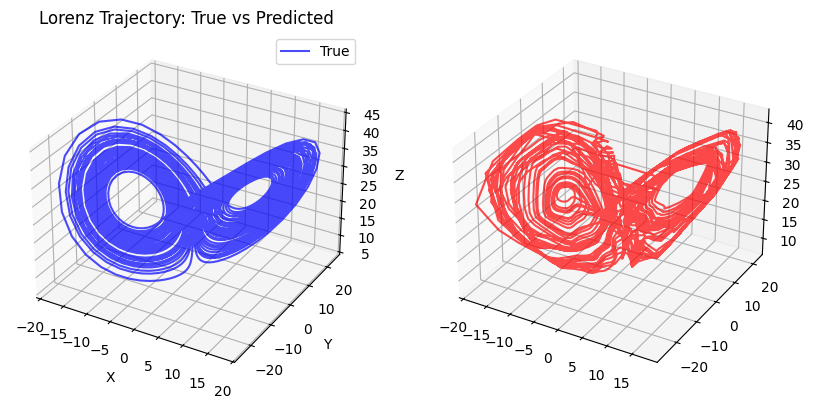

In [ ]:
def visualize_trajectory(traj_true, traj_pred=None, title="Lorenz Trajectory"):
    """
    traj_true: (N,3) оригинальная траектория
    traj_pred: (N,3) реконструированная моделью
    """
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot(traj_true[:,0], traj_true[:,1], traj_true[:,2], label='True', color='blue', alpha=0.7)
    if traj_pred is not None:
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.plot(traj_pred[:,0], traj_pred[:,1], traj_pred[:,2], label='Predicted', color='red', alpha=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()

if __name__ == '__main__':

    device = model_dict['device']
    X_delay = torch.tensor(X_delay_np, dtype=torch.float32, device=device)
    H0 = model_dict['encoder'](X_delay)
    A = model_dict['attention_graph'](H0)
    H_T = model_dict['grand'](H0, A, T=1.0, n_steps=30)
    traj_pred = model_dict['decoder'](H_T).detach().cpu().numpy()

    visualize_trajectory(traj_np, traj_pred, title="Lorenz Trajectory: True vs Predicted")

In [ ]:
!pip -q install torchdiffeq

Device: cuda
Prepared dataset: N=2955, D=60
Epoch 0001 | train-loss 2.556076e+02 | mse 2.485412e+02 | rmse 1.576519e+01 | time 0.106s
Epoch 0010 | train-loss 9.751919e+01 | mse 8.709438e+01 | rmse 9.332437e+00 | time 0.104s
Epoch 0020 | train-loss 8.491098e+01 | mse 8.138638e+01 | rmse 9.021440e+00 | time 0.017s
Epoch 0030 | train-loss 7.312068e+01 | mse 7.391059e+01 | rmse 8.597127e+00 | time 0.015s
Epoch 0040 | train-loss 7.325874e+01 | mse 7.291189e+01 | rmse 8.538846e+00 | time 0.014s
Epoch 0050 | train-loss 7.131184e+01 | mse 7.128940e+01 | rmse 8.443305e+00 | time 0.101s
Epoch 0060 | train-loss 7.100867e+01 | mse 7.089449e+01 | rmse 8.419886e+00 | time 0.098s
Epoch 0070 | train-loss 7.026860e+01 | mse 7.023679e+01 | rmse 8.380739e+00 | time 0.098s
Epoch 0080 | train-loss 6.961520e+01 | mse 6.953594e+01 | rmse 8.338821e+00 | time 0.106s
Epoch 0090 | train-loss 6.881465e+01 | mse 6.872130e+01 | rmse 8.289831e+00 | time 0.117s
Epoch 0100 | train-loss 6.782115e+01 | mse 6.771042e+01 

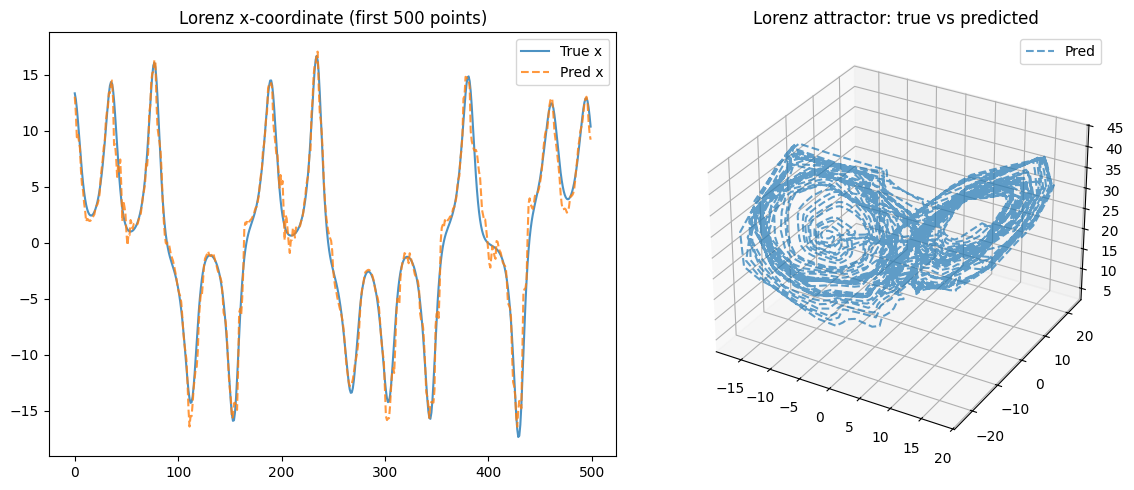

In [ ]:
"""
GRAND-style experiment for Lorenz attractor regression.

- Attention-based adjacency (computed from initial encoded node features X at t=0).
- ODE: dH/dt = - A_hat(X) @ f_theta(H)  (A_hat row-normalized attention)
- Integrator: torchdiffeq.odeint (as in original CGNN code)
- Decoder: Learnable low-rank "SVD-like" layer -> 3D coords
- Loss: MSE to true Lorenz 3D coords
"""

import time
import math
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    from torchdiffeq import odeint
except Exception as e:
    raise ImportError("Please install torchdiffeq (pip install torchdiffeq).") from e


def lorenz_step(u, sigma=10.0, beta=8/3, rho=28.0):
    x, y, z = u
    return np.array([sigma*(y-x), x*(rho-z)-y, x*y - beta*z], dtype=float)

def integrate_lorenz(u0, dt=0.01, steps=8000):
    traj = np.zeros((steps, 3), dtype=float)
    u = np.array(u0, dtype=float)
    for i in range(steps):
        k1 = lorenz_step(u)
        k2 = lorenz_step(u + 0.5*dt*k1)
        k3 = lorenz_step(u + 0.5*dt*k2)
        k4 = lorenz_step(u + dt*k3)
        u = u + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        traj[i] = u
    return traj

def nonlinear_map(X, D_high=30, seed=0):
    rng = np.random.RandomState(seed)
    W = rng.randn(3, D_high) * 0.8
    b = rng.randn(D_high) * 0.1
    lin = X.dot(W) + b
    return np.concatenate([np.tanh(lin), lin**2, lin**3], axis=1)

def delay_embed(series, tau, m):
    N = len(series)
    M = N - (m-1)*tau
    if M <= 0:
        raise ValueError('Too large tau/m for series length')
    Y = np.zeros((M, m), dtype=float)
    for i in range(M):
        for j in range(m):
            Y[i, j] = series[i + j*tau]
    return Y


class Meter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = None
        self.sum = 0
        self.cnt = 0
    def update(self, val):
        self.val = val
        self.sum += val
        self.cnt += 1
    def get_average(self):
        if self.cnt == 0:
            return 0
        return self.sum / self.cnt
    def get_value(self):
        return self.val

class DummyDataset(object):
    def __init__(self, data, num_classes):
        self.data = data
        self.num_classes = num_classes

class DummyData(object):
    def __init__(self, edge_index=None, edge_Attr=None, num_nodes=None):
        self.edge_index = edge_index
        self.edge_attr = edge_Attr
        self.num_nodes = num_nodes


class AttentionAdjacency(nn.Module):
    def __init__(self, in_dim, att_dim=None, att_dropout=0.0, add_self_loop=True):
        super().__init__()
        self.in_dim = in_dim
        self.att_dim = att_dim or in_dim
        self.q_proj = nn.Linear(in_dim, self.att_dim, bias=False)
        self.k_proj = nn.Linear(in_dim, self.att_dim, bias=False)
        self.scale = 1.0 / math.sqrt(self.att_dim)
        self.att_dropout = nn.Dropout(att_dropout) if att_dropout > 0 else None
        self.add_self_loop = add_self_loop

    def forward(self, X):
        Q = self.q_proj(X)
        K = self.k_proj(X)
        sim = torch.matmul(Q, K.transpose(0,1)) * self.scale
        if self.add_self_loop:
            diag = torch.diag(torch.full((X.shape[0],), 1.0, dtype=sim.dtype, device=sim.device))
            sim = sim + diag * 1.0
        A = torch.softmax(sim, dim=1)
        if self.att_dropout is not None and self.training:
            A = self.att_dropout(A)
            A = A / (A.sum(dim=1, keepdim=True) + 1e-12)
        return A


class ODEFunc(nn.Module):

    def __init__(self, feat_dim, hidden_dim, nonlin=nn.ReLU):
        super().__init__()
        self.feat_dim = feat_dim
        self.hidden_dim = hidden_dim
        self.f = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
            nonlin(),
            nn.Linear(hidden_dim, feat_dim)
        )
        self.register_buffer('A_hat', torch.zeros(1,1))
        self.nfe = 0

    def set_attention(self, A_hat):
        self.A_hat = A_hat.detach().clone()

    def forward(self, t, H):
        self.nfe += 1
        fH = self.f(H)
        dH = - torch.matmul(self.A_hat, fH)
        return dH

class ODEblock(nn.Module):
    def __init__(self, odefunc, t_span=torch.tensor([0.0, 1.0])):
        super().__init__()
        self.odefunc = odefunc
        self.t = t_span
        self.nfe = 0

    def set_x0_and_attention(self, x0_emb, attention_module):

        with torch.no_grad():
            A_hat = attention_module(x0_emb)
        self.odefunc.set_attention(A_hat)

    def forward(self, x, method='rk4', **ode_kwargs):
        t = self.t.type_as(x)
        z = odeint(self.odefunc, x, t, method=method, **ode_kwargs)[1]
        self.nfe += self.odefunc.nfe
        self.odefunc.nfe = 0
        return z


class LearnableSVD(nn.Module):
    def __init__(self, in_dim, rank=16, out_dim=3):
        super().__init__()
        self.W_u = nn.Linear(in_dim, rank, bias=False)
        self.W_v = nn.Linear(rank, out_dim, bias=True)
    def forward(self, H):
        U = self.W_u(H)
        out = self.W_v(U)
        return out


class CGNN_Regressor(nn.Module):
    def __init__(self, opt):

        super().__init__()
        self.opt = opt
        self.device = opt.get('device', torch.device('cpu'))
        self.fm = Meter()
        self.bm = Meter()

        D = opt['input_dim']
        feat_dim = opt['feat_dim']
        hidden_dim = opt.get('hidden_dim', 128)

        self.encoder = nn.Linear(D, feat_dim)

        self.att_builder = AttentionAdjacency(in_dim=feat_dim,
                                              att_dim=opt.get('att_dim', feat_dim),
                                              att_dropout=opt.get('att_dropout', 0.0),
                                              add_self_loop=True)

        self.odefunc = ODEFunc(feat_dim, hidden_dim)
        self.odeblock = ODEblock(self.odefunc, t_span=torch.tensor([0.0, float(opt.get('T', 1.0))]))

        self.decoder_svd = LearnableSVD(in_dim=feat_dim, rank=opt.get('svd_rank', 32), out_dim=3)

        self.final = nn.Identity()

    def forward(self, X_encoded):

        x = self.encoder(X_encoded)
        self.odeblock.set_x0_and_attention(x, self.att_builder)
        H0 = x.clone()
        H_T = self.odeblock(H0)
        H_T = F.relu(H_T)
        out = self.decoder_svd(H_T)
        out = self.final(out)
        return out


def prepare_data(seed=0, dt=0.01, steps=8000, drop_transient=2000, subsample=2, D_high=30, tau=5, m=10, use_components=6):
    np.random.seed(seed)
    traj = integrate_lorenz([1.0,1.0,1.0], dt=dt, steps=steps)
    traj = traj[drop_transient::subsample]
    high = nonlinear_map(traj, D_high=D_high, seed=seed)
    use_components = min(use_components, high.shape[1])
    delays = [delay_embed(high[:, i], tau, m) for i in range(use_components)]
    X_delay = np.hstack(delays)
    Mpoints = X_delay.shape[0]
    traj_trunc = traj[:Mpoints]
    return X_delay.astype(np.float32), traj_trunc.astype(np.float32)


def train_epoch(model, optimizer, X_tensor, Y_tensor):
    model.train()
    optimizer.zero_grad()
    pred = model(X_tensor)
    loss = F.mse_loss(pred, Y_tensor)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, X_tensor, Y_tensor):
    model.eval()
    pred = model(X_tensor)
    mse = F.mse_loss(pred, Y_tensor).item()
    rmse = math.sqrt(mse)
    return mse, rmse


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    X_np, traj_np = prepare_data(seed=0)
    N, D = X_np.shape
    print(f"Prepared dataset: N={N}, D={D}")

    opt = {
        'input_dim': D,
        'feat_dim': 64,
        'hidden_dim': 128,
        'svd_rank': 32,
        'T': 5.0,
        'att_dim': 64,
        'att_dropout': 0.0,
        'device': device
    }

    model = CGNN_Regressor(opt).to(device)
    X_tensor = torch.tensor(X_np, dtype=torch.float32, device=device)
    Y_tensor = torch.tensor(traj_np, dtype=torch.float32, device=device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

    epochs = 2000
    best_mse = float('inf')
    best_state = None
    for epoch in range(1, epochs+1):
        t0 = time.time()
        loss = train_epoch(model, optimizer, X_tensor, Y_tensor)
        mse, rmse = evaluate(model, X_tensor, Y_tensor)
        if mse < best_mse:
            best_mse = mse
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:04d} | train-loss {loss:.6e} | mse {mse:.6e} | rmse {rmse:.6e} | time {(time.time()-t0):.3f}s")

    if best_state is not None:
        model.load_state_dict(best_state)
    final_mse, final_rmse = evaluate(model, X_tensor, Y_tensor)
    print(f"Training finished. Best MSE on training set: {final_mse:.6e} RMSE: {final_rmse:.6e}")

    with torch.no_grad():
        preds = model(X_tensor).cpu().numpy()

    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12,5))

    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(traj_np[:500,0], label="True x", alpha=0.8)
    ax1.plot(preds[:500,0], label="Pred x", alpha=0.8, linestyle="--")
    ax1.set_title("Lorenz x-coordinate (first 500 points)")
    ax1.legend()

    ax2 = fig.add_subplot(1,2,2, projection='3d')
    ax2.plot(preds[:,0], preds[:,1], preds[:,2], label="Pred", alpha=0.7, linestyle="--")
    ax2.set_title("Lorenz attractor: true vs predicted")
    ax2.legend()

    plt.tight_layout()
    plt.show()
    return model, X_np, traj_np, preds

if __name__ == "__main__":
    main()


In [2]:
!pip -q install torch_geometric torchdiffeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00
